# Exploratory Data Analysis
## Goal:
- Understand the data as thoroughly as possible.
- Develop an initial modelling strategy focused on customer engagement.

## Basic Checklist
#### Shape Analysis:
- **Rows and columns**: 525,461 rows, 8 columns  
- **Variable types**: 4 categorical, 4 numerical  
- **Missing values**:  
  - Not many NaNs overall  
  - `CustomerID`: ~21% missing  
  - `Description`: ~1% missing

#### Content Analysis:
- **CustomerID**: We observe that rows with missing `CustomerID` share consistent patterns.  
  - 2,487 rows: negative quantity and price = 0  
  - 2,442 rows: missing `CustomerID`, quantity < 0, country = United Kingdom  
  - 2,121 rows: same as above + price = 0  
  This suggests that missing `CustomerID` rows are associated with similar abnormal transactions.

- **Invoice**: When the invoice starts with the letter `C`, it indicates a cancellation.  
  Most invoices longer than 6 characters appear to start with `C`.  
  After removing all digits from the invoice codes, we get three cases:  
  - empty string `''` → purely numeric invoices  
  - `C` → cancellations  
  - `A` → invoices starting with A  
  Only 3 invoices start with `A`.

- **StockCode**: The dataset description says StockCode should contain 5 digits, but we found 80,112 rows with longer codes.  
  The dataset documentation does not explain these longer StockCodes.


# Import libraries

In [1]:
import numpy as np 
import seaborn as sns 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import datetime as dt
pd.options.display.float_format = '{:20.2f}'.format 
pd.set_option('display.max_columns', 999)

# Import Data

In [2]:
data = pd.read_excel("../data/online_retail_II 4.xlsx")

In [5]:
df = data.copy()

In [6]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom


# Data Exploration

In [7]:
df.shape

(525461, 8)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [9]:
df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,525461.00,525461,525461.00,417534.00
mean,10.34,2010-06-28 11:37:36.845017856,4.69,15360.65
min,-9600.00,2009-12-01 07:45:00,-53594.36,12346.00
25%,1.00,2010-03-21 12:20:00,1.25,13983.00
50%,3.00,2010-07-06 09:51:00,2.10,15311.00
75%,10.00,2010-10-15 12:45:00,4.21,16799.00
max,19152.00,2010-12-09 20:01:00,25111.09,18287.00
std,107.42,NaN,146.13,1680.81


In [10]:
df.describe(include='O')

,Invoice,StockCode,Description,Country
count,525461,525461,522533,525461
unique,28816,4632,4681,40
top,537434,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
freq,675,3516,3549,485852


In [11]:
(df.isna().sum()/df.shape[0]).sort_values(ascending=False)

Customer ID                   0.21
Description                   0.01
Invoice                       0.00
StockCode                     0.00
Quantity                      0.00
InvoiceDate                   0.00
Price                         0.00
Country                       0.00
dtype: float64

In [12]:
df[df['Customer ID'].isna()].head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
263,489464,21733,85123a mixed,-96,2009-12-01 10:52:00,0.00,NaN,United Kingdom
283,489463,71477,short,-240,2009-12-01 10:52:00,0.00,NaN,United Kingdom
284,489467,85123A,21733 mixed,-192,2009-12-01 10:53:00,0.00,NaN,United Kingdom
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.00,NaN,United Kingdom
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom
578,489525,85227,SET/6 3D KIT CARDS FOR KIDS,1,2009-12-01 11:49:00,0.85,NaN,United Kingdom
1055,489548,22271,FELTCRAFT DOLL ROSIE,1,2009-12-01 12:32:00,2.95,NaN,United Kingdom
1056,489548,22254,FELT TOADSTOOL LARGE,12,2009-12-01 12:32:00,1.25,NaN,United Kingdom
1057,489548,22273,FELTCRAFT DOLL MOLLY,3,2009-12-01 12:32:00,2.95,NaN,United Kingdom
1058,489548,22195,LARGE HEART MEASURING SPOONS,1,2009-12-01 12:32:00,1.65,NaN,United Kingdom


In [13]:
df[(df['Customer ID'].isna()) & (df['Quantity'] <0)].shape

(2487, 8)

In [14]:
df[(df['Customer ID'].isna()) & (df['Quantity'] <0) & (df['Country']=='United Kingdom')].shape

(2442, 8)

In [15]:
df[(df['Customer ID'].isna()) & (df['Quantity'] <0) & (df['Country']=='United Kingdom') & (df['Price']==0)].shape

(2121, 8)

In [16]:
df[df['Quantity']<0].head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.00,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.00,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.00,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.00,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.00,Australia
183,C489449,21871,SAVE THE PLANET MUG,-12,2009-12-01 10:33:00,1.25,16321.00,Australia
184,C489449,84946,ANTIQUE SILVER TEA GLASS ETCHED,-12,2009-12-01 10:33:00,1.25,16321.00,Australia
185,C489449,84970S,HANGING HEART ZINC T-LIGHT HOLDER,-24,2009-12-01 10:33:00,0.85,16321.00,Australia
186,C489449,22090,PAPER BUNTING RETRO SPOTS,-12,2009-12-01 10:33:00,2.95,16321.00,Australia
196,C489459,90200A,PURPLE SWEETHEART BRACELET,-3,2009-12-01 10:44:00,4.25,17592.00,United Kingdom


In [17]:
df['Invoice'] = df['Invoice'].astype('str')
df[df['Invoice'].str.match("^\\d{6}$")==False]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.00,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.00,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.00,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.00,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.00,Australia
...,...,...,...,...,...,...,...,...
524695,C538123,22956,36 FOIL HEART CAKE CASES,-2,2010-12-09 15:41:00,2.10,12605.00,Germany
524696,C538124,M,Manual,-4,2010-12-09 15:43:00,0.50,15329.00,United Kingdom
524697,C538124,22699,ROSES REGENCY TEACUP AND SAUCER,-1,2010-12-09 15:43:00,2.95,15329.00,United Kingdom
524698,C538124,22423,REGENCY CAKESTAND 3 TIER,-1,2010-12-09 15:43:00,12.75,15329.00,United Kingdom


In [18]:
df['Invoice'].str.replace('[0-9]', '', regex=True).unique()

array(['', 'C', 'A'], dtype=object)

In [19]:
df[df['Invoice'].str.startswith('A')]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.36,NaN,United Kingdom
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.79,NaN,United Kingdom
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.87,NaN,United Kingdom


In [20]:
df['StockCode'] = df['StockCode'].astype('str')
df[df['StockCode'].str.match('^\\d{5}$')==False]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
12,489436,48173C,DOOR MAT BLACK FLOCK,10,2009-12-01 09:06:00,5.95,13078.00,United Kingdom
23,489436,35004B,SET OF 3 BLACK FLYING DUCKS,12,2009-12-01 09:06:00,4.65,13078.00,United Kingdom
28,489436,84596F,SMALL MARSHMALLOWS PINK BOWL,8,2009-12-01 09:06:00,1.25,13078.00,United Kingdom
...,...,...,...,...,...,...,...,...
525387,538170,84029E,RED WOOLLY HOTTIE WHITE HEART.,2,2010-12-09 19:32:00,3.75,13969.00,United Kingdom
525388,538170,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,2,2010-12-09 19:32:00,3.75,13969.00,United Kingdom
525389,538170,85232B,SET OF 3 BABUSHKA STACKING TINS,2,2010-12-09 19:32:00,4.95,13969.00,United Kingdom
525435,538171,47591D,PINK FAIRY CAKE CHILDRENS APRON,1,2010-12-09 20:01:00,1.95,17530.00,United Kingdom


In [21]:
df[(df['StockCode'].str.match('^\\d{5}$')==False) &  (df['StockCode'].str.match('^\\d{5}[a-zA-Z]+$')==False)]['StockCode'].unique()

array(['POST', 'D', 'DCGS0058', 'DCGS0068', 'DOT', 'M', 'DCGS0004',
       'DCGS0076', 'C2', 'BANK CHARGES', 'DCGS0003', 'TEST001',
       'gift_0001_80', 'DCGS0072', 'gift_0001_20', 'DCGS0044', 'TEST002',
       'gift_0001_10', 'gift_0001_50', 'DCGS0066N', 'gift_0001_30',
       'PADS', 'ADJUST', 'gift_0001_40', 'gift_0001_60', 'gift_0001_70',
       'gift_0001_90', 'DCGSSGIRL', 'DCGS0006', 'DCGS0016', 'DCGS0027',
       'DCGS0036', 'DCGS0039', 'DCGS0060', 'DCGS0056', 'DCGS0059', 'GIFT',
       'DCGSLBOY', 'm', 'DCGS0053', 'DCGS0062', 'DCGS0037', 'DCGSSBOY',
       'DCGSLGIRL', 'S', 'DCGS0069', 'DCGS0070', 'DCGS0075', 'B',
       'DCGS0041', 'ADJUST2', '47503J ', 'C3', 'SP1002', 'AMAZONFEE'],
      dtype=object)

All these postal codes do not follow the pattern indicated by the dataset.




In [22]:
df[df['StockCode'].str.contains('^DOT')]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
2379,489597,DOT,DOTCOM POSTAGE,1,2009-12-01 14:28:00,647.19,NaN,United Kingdom
2539,489600,DOT,DOTCOM POSTAGE,1,2009-12-01 14:43:00,55.96,NaN,United Kingdom
2551,489601,DOT,DOTCOM POSTAGE,1,2009-12-01 14:44:00,68.39,NaN,United Kingdom
2571,489602,DOT,DOTCOM POSTAGE,1,2009-12-01 14:45:00,59.35,NaN,United Kingdom
2619,489603,DOT,DOTCOM POSTAGE,1,2009-12-01 14:46:00,42.39,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
524272,538071,DOT,DOTCOM POSTAGE,1,2010-12-09 14:09:00,885.94,NaN,United Kingdom
524887,538148,DOT,DOTCOM POSTAGE,1,2010-12-09 16:26:00,547.32,NaN,United Kingdom
525000,538149,DOT,DOTCOM POSTAGE,1,2010-12-09 16:27:00,620.68,NaN,United Kingdom
525126,538153,DOT,DOTCOM POSTAGE,1,2010-12-09 16:31:00,822.94,NaN,United Kingdom


## Notes 


### Stock Code

The StockCode is supposed to follow the pattern [0-9]{5}, but it seems there are also valid values that match [0-9]{5}[a-zA-Z]+.




There are also other values:
- **DCGS**: Seems valid, but some quantities are negative and some customers have missing IDs → **excluded from clustering**
- **D**: Seems valid, represents out‑of‑stock items → **excluded from clustering**
- **DOT**: Seems valid, represents shipping charges → **excluded from clustering**
- **M / m**: Seems valid, represents manual transactions → **excluded from clustering**
- **C2**: Transport operation → **excluded**
- **C3**: Only one transaction → **excluded**
- **Bank charges / B** → **excluded**
- **S**: Sample sent to the customer → **excluded**
- **TESTXXX**: Testing data, not valid → **excluded**
- **GIFT_XXX**: Gift‑card purchase → **excluded**
- **PADS**: Seems valid → **included in clustering**
- **SP1002**: Special request; only two transactions, three seem valid and one has zero price → **excluded for now**
- **AMAZONFEE**: Appears to be Amazon delivery fees → **excluded for now**
- **ADJUST**: Account adjustments made by admins → **excluded for now**


## Data Cleaning

In [23]:
cleaned_df = df.copy()

In [24]:
cleaned_df['Invoice'] = cleaned_df['Invoice'].astype('str') 

mask = (
    cleaned_df['Invoice'].str.match('^\\d{6}$') == True
)

cleaned_df = cleaned_df[mask]

cleaned_df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.00,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.00,United Kingdom


In [25]:
cleaned_df['StockCode'] = cleaned_df['StockCode'].astype('str') 

mask = (
    (cleaned_df['StockCode'].str.match('^\\d{5}$') == True)
    | (cleaned_df['StockCode'].str.match('^\\d{5}[a-zA-Z]+$') == True)   
    | (cleaned_df['StockCode'].str.match('^PADS$') ==True)                             
)

cleaned_df = cleaned_df[mask] 

In [26]:
cleaned_df.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.00,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.00,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.00,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.00,United Kingdom


In [27]:
cleaned_df.dropna(subset=['Customer ID'], inplace = True)

/var/folders/gg/dm5j6jg565j0bblwgpt9ggsw0000gn/T/ipykernel_3069/207711280.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df.dropna(subset=['Customer ID'], inplace = True)


In [28]:
cleaned_df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,406337.00,406337,406337.00,406337.00
mean,13.62,2010-07-01 10:11:06.543288320,2.99,15373.63
min,1.00,2009-12-01 07:45:00,0.00,12346.00
25%,2.00,2010-03-26 14:01:00,1.25,14004.00
50%,5.00,2010-07-09 15:48:00,1.95,15326.00
75%,12.00,2010-10-14 17:09:00,3.75,16814.00
max,19152.00,2010-12-09 20:01:00,295.00,18287.00
std,97.00,NaN,4.29,1677.37


Even after removing some unusual transactions, there are still orders with a price of 0, which is not possible. We need to address this.

In [29]:
cleaned_df[cleaned_df['Price']==0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
4674,489825,22076,6 RIBBONS EMPIRE,12,2009-12-02 13:34:00,0.00,16126.00,United Kingdom
6781,489998,48185,DOOR MAT FAIRY CAKE,2,2009-12-03 11:19:00,0.00,15658.00,United Kingdom
18738,490961,22065,CHRISTMAS PUDDING TRINKET POT,1,2009-12-08 15:25:00,0.00,14108.00,United Kingdom
18739,490961,22142,CHRISTMAS CRAFT WHITE FAIRY,12,2009-12-08 15:25:00,0.00,14108.00,United Kingdom
32916,492079,85042,ANTIQUE LILY FAIRY LIGHTS,8,2009-12-15 13:49:00,0.00,15070.00,United Kingdom
40101,492760,21143,ANTIQUE GLASS HEART DECORATION,12,2009-12-18 14:22:00,0.00,18071.00,United Kingdom
47126,493761,79320,FLAMINGO LIGHTS,24,2010-01-06 14:54:00,0.00,14258.00,United Kingdom
48342,493899,22355,"CHARLOTTE BAG , SUKI DESIGN",10,2010-01-08 10:43:00,0.00,12417.00,Belgium
57619,494607,21533,RETRO SPOT LARGE MILK JUG,12,2010-01-15 12:43:00,0.00,16858.00,United Kingdom
111348,500073,21662,VINTAGE GLASS COFFEE CADDY,1,2010-03-04 11:44:00,0.00,13047.00,United Kingdom


In [30]:
len(cleaned_df[cleaned_df['Price']==0])

28

In [31]:
cleaned_df = cleaned_df[cleaned_df['Price'] > 0.001]

In [32]:
cleaned_df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,406295.00,406295,406295.00,406295.00
mean,13.62,2010-07-01 10:18:05.997415424,2.99,15373.75
min,1.00,2009-12-01 07:45:00,0.03,12346.00
25%,2.00,2010-03-26 14:01:00,1.25,14006.00
50%,5.00,2010-07-09 15:48:00,1.95,15326.00
75%,12.00,2010-10-14 17:09:00,3.75,16814.00
max,19152.00,2010-12-09 20:01:00,295.00,18287.00
std,97.00,NaN,4.29,1677.33


In [33]:
cleaned_df['Price'].min()

0.03

We cleaned items with zero prices, but since the minimum is now 0.001, the dataset describe() still reports a minimum of 0.

In [34]:
len(cleaned_df) / len(df)

0.7732162805612596

We therefore kept about 70% of the original dataset, which is reasonable.

## Feature Engineering

In [35]:
cleaned_df['SalesLineTotal'] = cleaned_df['Quantity'] * cleaned_df['Price']

In [36]:
aggregated_df = (
    cleaned_df.groupby(by='Customer ID', as_index=False)
    .agg(MonetaryValue = ('SalesLineTotal', 'sum'), 
         Frequency = ('Invoice', 'nunique'), 
         LastInvoiceDate = ('InvoiceDate', 'max'))

)


In [37]:
aggregated_df.head()

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate
0,12346.00,169.36,2,2010-06-28 13:53:00
1,12347.00,1323.32,2,2010-12-07 14:57:00
2,12348.00,221.16,1,2010-09-27 14:59:00
3,12349.00,2221.14,2,2010-10-28 08:23:00
4,12351.00,300.93,1,2010-11-29 15:23:00


In [38]:
max_invoice_date = aggregated_df['LastInvoiceDate'].max()

aggregated_df['Recency'] = (max_invoice_date - aggregated_df['LastInvoiceDate']).dt.days

In [39]:
aggregated_df

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,Recency
0,12346.00,169.36,2,2010-06-28 13:53:00,164
1,12347.00,1323.32,2,2010-12-07 14:57:00,2
2,12348.00,221.16,1,2010-09-27 14:59:00,73
3,12349.00,2221.14,2,2010-10-28 08:23:00,42
4,12351.00,300.93,1,2010-11-29 15:23:00,10
...,...,...,...,...,...
4280,18283.00,641.77,6,2010-11-22 15:30:00,17
4281,18284.00,411.68,1,2010-10-04 11:33:00,66
4282,18285.00,377.00,1,2010-02-17 10:24:00,295
4283,18286.00,1246.43,2,2010-08-20 11:57:00,111


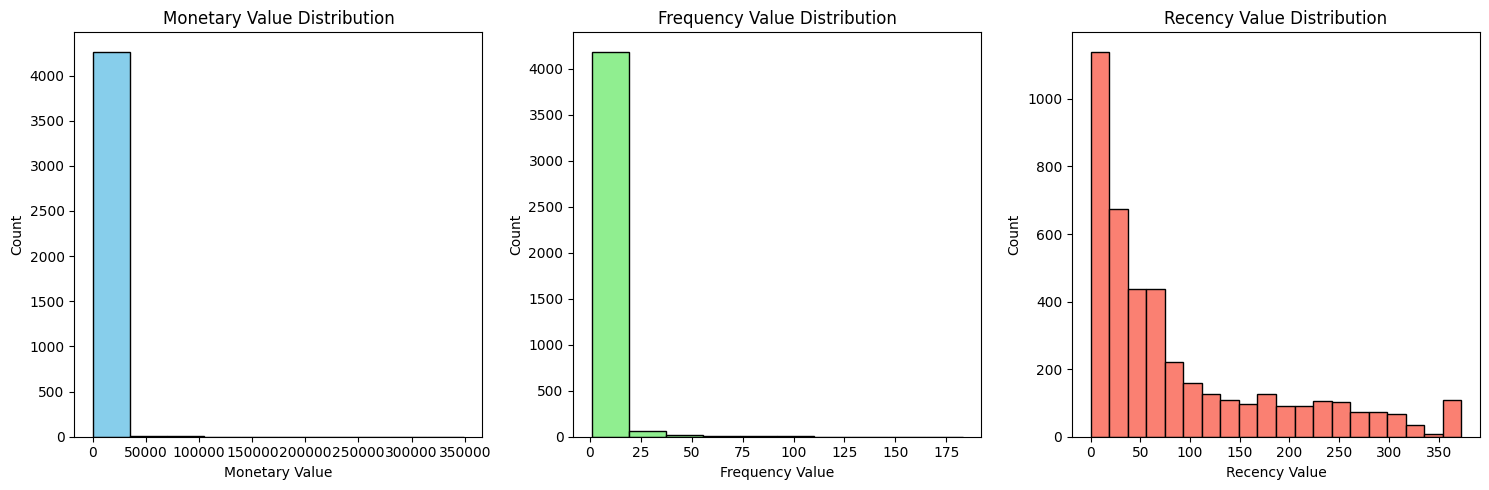

In [40]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(aggregated_df['MonetaryValue'], bins=10, color = 'skyblue', edgecolor = 'black')
plt.title('Monetary Value Distribution')
plt.xlabel('Monetary Value')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
plt.hist(aggregated_df['Frequency'], bins=10, color = 'lightgreen', edgecolor = 'black')
plt.title('Frequency Value Distribution')
plt.xlabel('Frequency Value')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
plt.hist(aggregated_df['Recency'], bins=20, color = 'salmon', edgecolor = 'black')
plt.title('Recency Value Distribution')
plt.xlabel('Recency Value')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


The Recency distribution looks good, with no outliers.
However, Monetary and Frequency have many outliers, which we need to address.

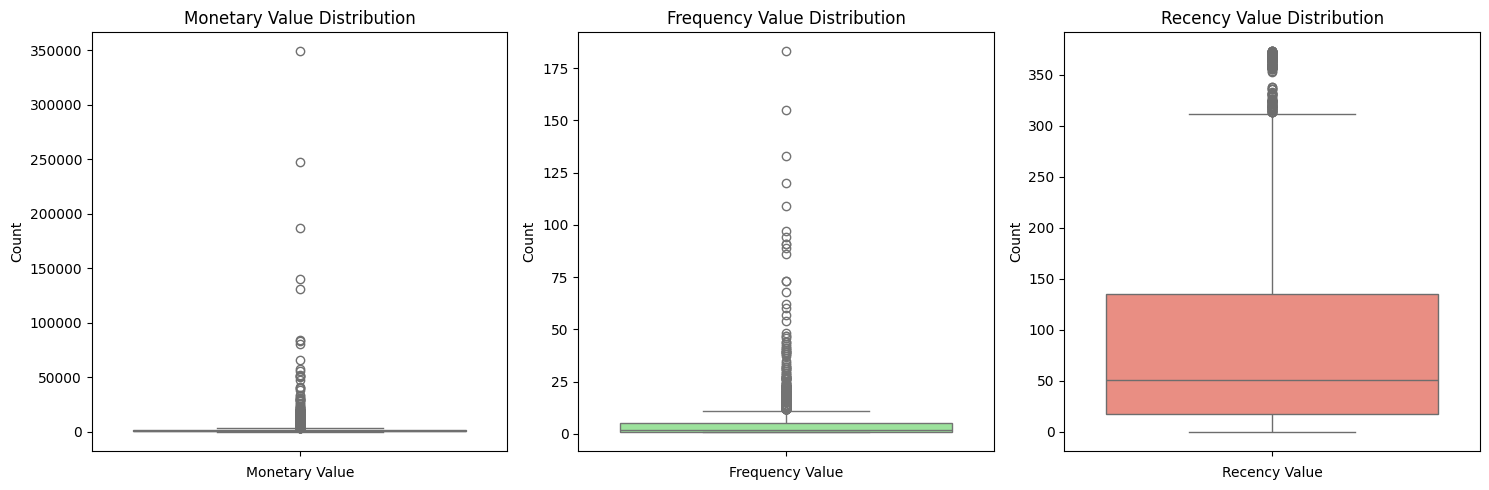

In [41]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(data = aggregated_df['MonetaryValue'], color='skyblue')
plt.title('Monetary Value Distribution')
plt.xlabel('Monetary Value')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
sns.boxplot(data = aggregated_df['Frequency'], color = 'lightgreen')
plt.title('Frequency Value Distribution')
plt.xlabel('Frequency Value')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
sns.boxplot(data = aggregated_df['Recency'],  color = 'salmon')
plt.title('Recency Value Distribution')
plt.xlabel('Recency Value')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


In [42]:
M_Q1 = aggregated_df['MonetaryValue'].quantile(0.25)
M_Q3 = aggregated_df['MonetaryValue'].quantile(0.75)
M_IQR = M_Q3 - M_Q1 

Monetary_outliers_df = aggregated_df[(aggregated_df['MonetaryValue'] >  (M_Q3 + 1.5 * M_IQR)) | (aggregated_df['MonetaryValue'] < (M_Q1 - 1.5 * M_IQR))].copy()

In [43]:
Monetary_outliers_df.describe()

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,Recency
count,423.00,423.00,423.00,423,423.00
mean,15103.04,12188.10,17.17,2010-11-09 12:26:02.978723328,30.04
min,12357.00,3802.04,1.00,2009-12-10 18:03:00,0.00
25%,13622.00,4605.94,8.00,2010-11-08 13:17:30,3.00
50%,14961.00,6191.32,12.00,2010-11-26 12:19:00,13.00
75%,16692.00,10273.24,18.00,2010-12-06 10:34:30,31.00
max,18260.00,349164.35,183.00,2010-12-09 19:32:00,364.00
std,1728.66,25830.85,19.73,NaN,51.54


In [44]:
F_Q1 = aggregated_df['Frequency'].quantile(0.25)
F_Q3 = aggregated_df['Frequency'].quantile(0.75)
F_IQR = F_Q3 - F_Q1 

Frequency_outliers_df = aggregated_df[(aggregated_df['Frequency'] >  (F_Q3 + 1.5 * F_IQR)) | (aggregated_df['Frequency'] < (F_Q1 - 1.5 * F_IQR))].copy()

In [45]:
Frequency_outliers_df.describe()

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,Recency
count,279.00,279.00,279.00,279,279.00
mean,15352.66,14409.71,23.81,2010-11-23 11:06:20.645161216,16.09
min,12437.00,1094.39,12.00,2010-05-12 16:51:00,0.00
25%,13800.00,4331.56,13.00,2010-11-20 13:14:30,2.00
50%,15465.00,6615.77,17.00,2010-12-02 10:46:00,7.00
75%,16828.50,11692.41,23.00,2010-12-07 11:08:30,19.00
max,18260.00,349164.35,183.00,2010-12-09 19:32:00,211.00
std,1748.43,31381.74,21.93,NaN,26.59


Some outliers in Monetary are also outliers in Frequency, so there can be overlap: customers who spend a lot logically place many orders.  
So we already have three groups: Monetary outliers, Frequency outliers, and customers who are outliers in both Monetary and Frequency.

In [46]:
non_outliers_df = aggregated_df[(~ aggregated_df.index.isin(Monetary_outliers_df.index)) & 
                                (~ aggregated_df.index.isin(Frequency_outliers_df.index))]

So we keep all customers who are neither Monetary outliers nor Frequency outliers.

In [47]:
non_outliers_df.describe()

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,Recency
count,3809.00,3809.00,3809.00,3809,3809.00
mean,15376.48,885.50,2.86,2010-09-03 11:16:46.516146176,97.08
min,12346.00,1.55,1.00,2009-12-01 10:49:00,0.00
25%,13912.00,279.91,1.00,2010-07-08 14:48:00,22.00
50%,15389.00,588.05,2.00,2010-10-12 16:25:00,58.00
75%,16854.00,1269.05,4.00,2010-11-17 13:14:00,154.00
max,18287.00,3788.21,11.00,2010-12-09 20:01:00,373.00
std,1693.20,817.67,2.24,NaN,98.11


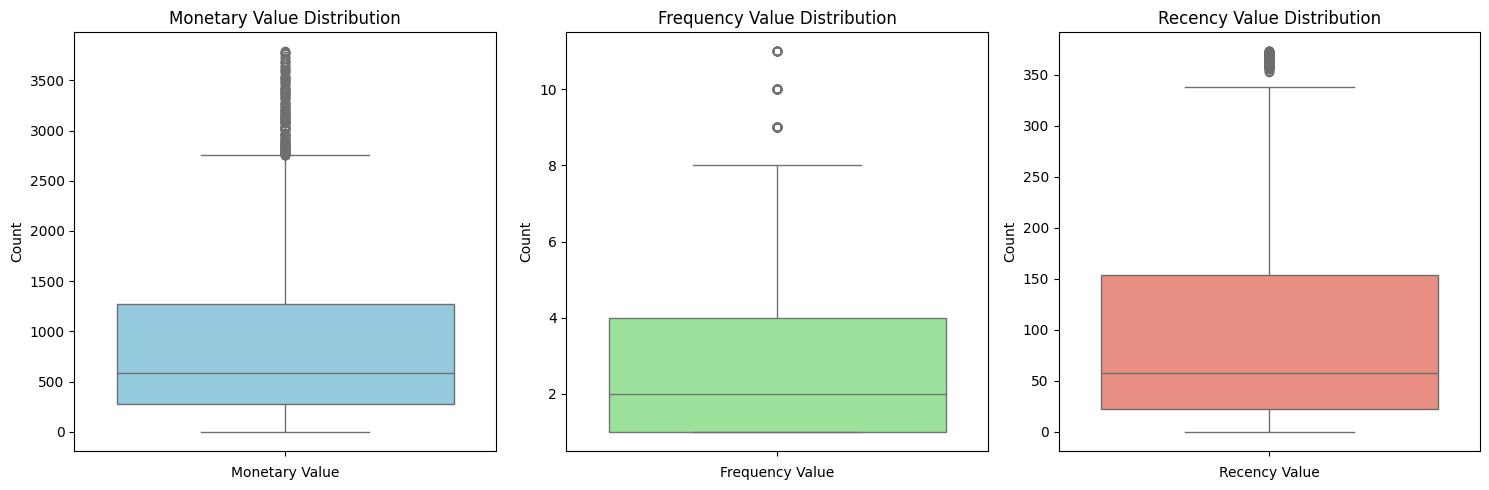

In [48]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(data = non_outliers_df['MonetaryValue'], color='skyblue')
plt.title('Monetary Value Distribution')
plt.xlabel('Monetary Value')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
sns.boxplot(data = non_outliers_df['Frequency'], color = 'lightgreen')
plt.title('Frequency Value Distribution')
plt.xlabel('Frequency Value')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
sns.boxplot(data = non_outliers_df['Recency'],  color = 'salmon')
plt.title('Recency Value Distribution')
plt.xlabel('Recency Value')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


So we can see that the distributions are now much clearer.

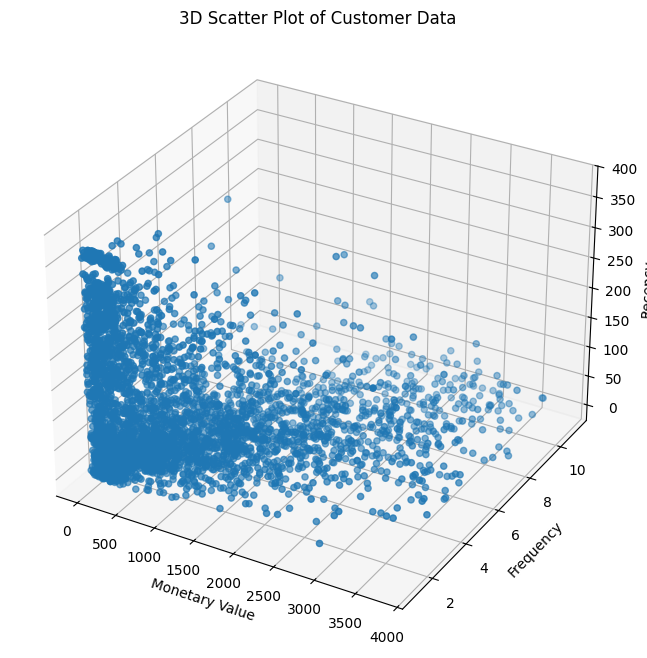

In [49]:
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(projection="3d")

scatter = ax.scatter(non_outliers_df["MonetaryValue"], non_outliers_df["Frequency"], non_outliers_df["Recency"])

ax.set_xlabel('Monetary Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

ax.set_title('3D Scatter Plot of Customer Data')

plt.show()

We note that the three variable axes are not on the same scale.

Standard scaling transforms the features of your data to have a mean of 0 and a standard deviation of 1, ensuring that each feature contributes equally to the analysis.

$$
z = \frac{x - \mu}{\sigma}
$$


With `z` the standardized variable, `x` the original variable, `μ` the mean, and `σ` the standard deviation.

In [50]:
scaler = StandardScaler()

scaled_data = scaler.fit_transform(non_outliers_df[["MonetaryValue", "Frequency", "Recency"]])

scaled_data

array([[-0.87594534, -0.38488934,  0.68214853],
       [ 0.53551441, -0.38488934, -0.96925093],
       [-0.81258645, -0.83063076, -0.24548944],
       ...,
       [-0.62197163, -0.83063076,  2.01753946],
       [ 0.44146683, -0.38488934,  0.14187587],
       [ 1.72488782,  0.50659348, -0.81634357]])

When using `StandardScaler`, it’s important to restore the original index and column names, because after scaling you get a NumPy array.

In [51]:
cols = ["MonetaryValue", "Frequency", "Recency"]
scaled_data = pd.DataFrame(
    scaled_data,
    columns=non_outliers_df[cols].columns,
    index=non_outliers_df[cols].index,
)


In [52]:
scaled_data

,MonetaryValue,Frequency,Recency
0,-0.88,-0.38,0.68
1,0.54,-0.38,-0.97
2,-0.81,-0.83,-0.25
3,1.63,-0.38,-0.56
4,-0.72,-0.83,-0.89
...,...,...,...
4280,-0.30,1.40,-0.82
4281,-0.58,-0.83,-0.32
4282,-0.62,-0.83,2.02
4283,0.44,-0.38,0.14


In [53]:
print("The std of our features are:\n")
print(scaled_data[["MonetaryValue", "Frequency", "Recency"]].std(axis=0))

The std of our features are:

MonetaryValue                   1.00
Frequency                       1.00
Recency                         1.00
dtype: float64


In [68]:
print("The average of our features are :\n")
print(scaled_data[["MonetaryValue", "Frequency", "Recency"]].mean(axis=0))

The average of our features are :

MonetaryValue                   0.00
Frequency                      -0.00
Recency                         0.00
dtype: float64


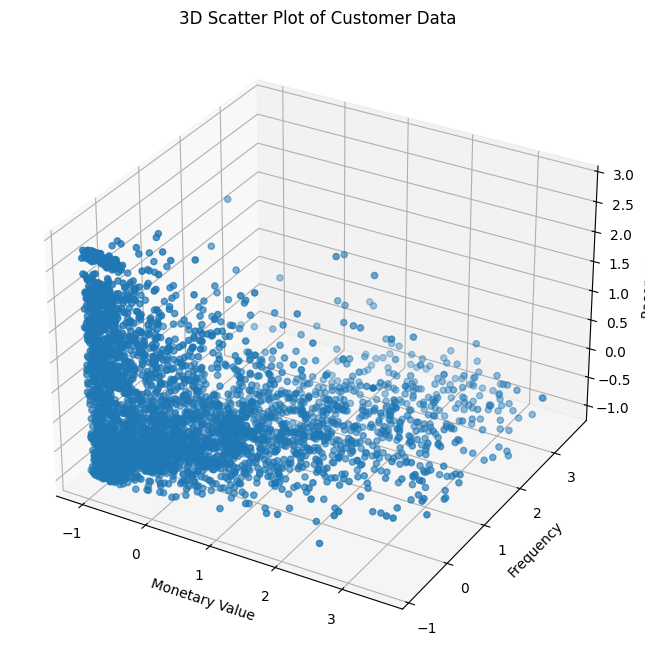

In [55]:
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(projection="3d")

scatter = ax.scatter(scaled_data["MonetaryValue"], scaled_data["Frequency"], scaled_data["Recency"])

ax.set_xlabel('Monetary Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

ax.set_title('3D Scatter Plot of Customer Data')

plt.show()

Now all of our features are on the same scale.

##  Clustering

In machine learning, this type of model is used when we want to classify our data in an unsupervised way. 
Unlike what we saw in the previous chapter, clustering groups data solely based on similarity, without any notion of “correct” or “incorrect” classes.  
For example:
- Classer des images ou des objets selon leur ressemblance
- Segmenter une base de données de clients, selon leurs habitudes de consommation • Regrouper des documents selon leur contenu.


Clustering is therefore an interesting approach when we want to let the machine propose its own solution, and thus discover a different perspective from our own.

![Titre](../images/plot1.png)


*Source: Guillaume Saint‑Cirgue, Machine Learnia — Clustering chapter.*


## Inertia (Within-Cluster Sum of Squares)

Inertia measures how compact the clusters are.  
It is defined as the sum of squared Euclidean distances between each point and the centroid of its assigned cluster:

$$
\text{Inertia} = \sum_{k=1}^{K} \sum_{x_i \in C_k} \|x_i - \mu_k\|^2
$$

- Lower inertia means tighter, more compact clusters.  
- As K increases, inertia always decreases.  
- The elbow method looks for the point where inertia starts decreasing more slowly.


![Titre](../images/elbow.png)


*Source: Guillaume Saint‑Cirgue, Machine Learnia — Clustering chapter.*


## Silhouette Score

The silhouette score measures how well each point fits within its assigned cluster compared to other clusters.

For each point \(i\):

$$
s(i) = \frac{b(i) - a(i)}{\max\{a(i),\, b(i)\}}
$$

where:  
- $a(i)$ = average distance from $(i)$ to other points in the same cluster  
- $b(i)$ = lowest average distance from $(i)$ to points in the nearest other cluster  

The score ranges from -1 to 1:  
- Close to 1 → well‑clustered  
- Around 0 → overlapping clusters  
- Negative → probably assigned to the wrong cluster


## K-means

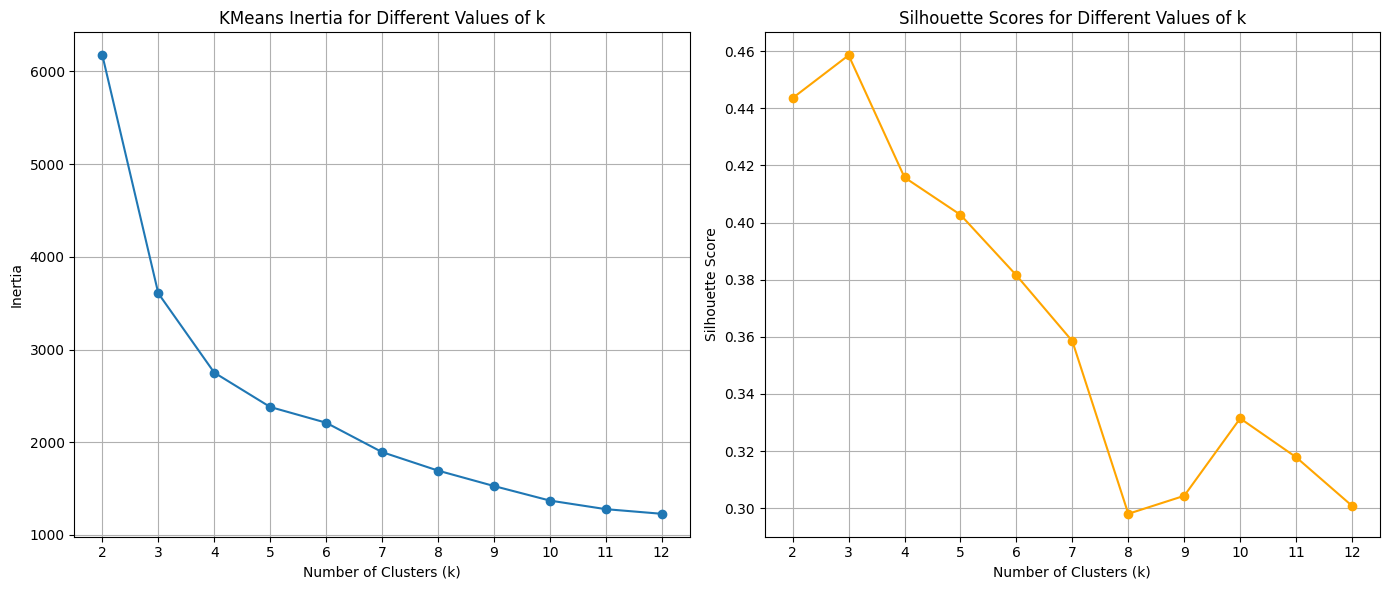

In [56]:
max_k = 12

inertia = []
silhoutte_scores = []
k_values = range(2, max_k + 1)

for k in k_values:

    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=1000)

    cluster_labels = kmeans.fit_predict(scaled_data)

    sil_score = silhouette_score(scaled_data, cluster_labels)

    silhoutte_scores.append(sil_score)

    inertia.append(kmeans.inertia_)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, marker='o')
plt.title('KMeans Inertia for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_values, silhoutte_scores, marker='o', color='orange')
plt.title('Silhouette Scores for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)

plt.tight_layout()
plt.show()

The elbow method remains useful and very visual, but its interpretation can be subjective. Still, let’s try to be objective.

Inertia drops sharply up to \(k=3\). Between \(k=4\) and \(k=5\), the decrease is small, which suggests we are splitting a cluster whose points were already close.

The silhouette score is highest for \(k=3\), indicating the best separation between clusters. From \(k=4\) onward, the score gradually decreases, suggesting less distinct groups. There is a slight increase around \(k=10\), but it remains below the maximum reached at \(k=3\); this reinforces the idea that \(k=3\) is the most relevant choice by this criterion.

Using the elbow method, inertia still drops noticeably from \(k=3\) to \(k=4\), which means that moving to 4 clusters yields more compact groups. Even though the silhouette score is highest at \(k=3\), a reasonable compromise between the two metrics is \(k=4\).

In [57]:
kmeans = KMeans(n_clusters=4, random_state=42, max_iter=1000)

cluster_labels = kmeans.fit_predict(scaled_data)

cluster_labels


array([1, 0, 2, ..., 1, 0, 0], dtype=int32)

In [58]:
non_outliers_df["Cluster"] = cluster_labels

non_outliers_df

/var/folders/gg/dm5j6jg565j0bblwgpt9ggsw0000gn/T/ipykernel_3069/3577770544.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_outliers_df["Cluster"] = cluster_labels


,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,Recency,Cluster
0,12346.00,169.36,2,2010-06-28 13:53:00,164,1
1,12347.00,1323.32,2,2010-12-07 14:57:00,2,0
2,12348.00,221.16,1,2010-09-27 14:59:00,73,2
3,12349.00,2221.14,2,2010-10-28 08:23:00,42,0
4,12351.00,300.93,1,2010-11-29 15:23:00,10,2
...,...,...,...,...,...,...
4280,18283.00,641.77,6,2010-11-22 15:30:00,17,0
4281,18284.00,411.68,1,2010-10-04 11:33:00,66,2
4282,18285.00,377.00,1,2010-02-17 10:24:00,295,1
4283,18286.00,1246.43,2,2010-08-20 11:57:00,111,0


Text(0.5, 0.92, '3D Scatter Plot of Customer Data by Cluster')

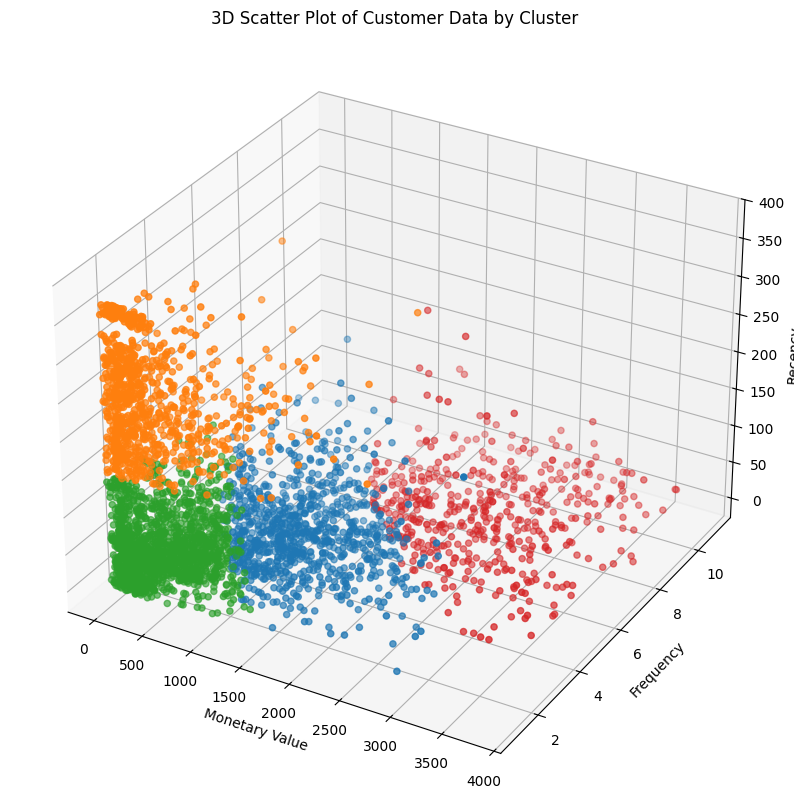

In [59]:
cluster_colors = {0: '#1f77b4',  
                  1: '#ff7f0e',  
                  2: '#2ca02c',  
                  3: '#d62728'}  

colors = non_outliers_df['Cluster'].map(cluster_colors)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

scatter = ax.scatter(non_outliers_df['MonetaryValue'], 
                     non_outliers_df['Frequency'], 
                     non_outliers_df['Recency'], 
                     c=colors,  
                     marker='o')

ax.set_xlabel('Monetary Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

ax.set_title('3D Scatter Plot of Customer Data by Cluster')

In a clustering model, violin plots are very useful to understand the distribution of each variable across clusters. I also added a violin plot of the overall distribution (without cluster distinction) as a reference.

In [60]:
non_outliers_df[non_outliers_df['Cluster'] == 3]['Recency'].median()

20.0

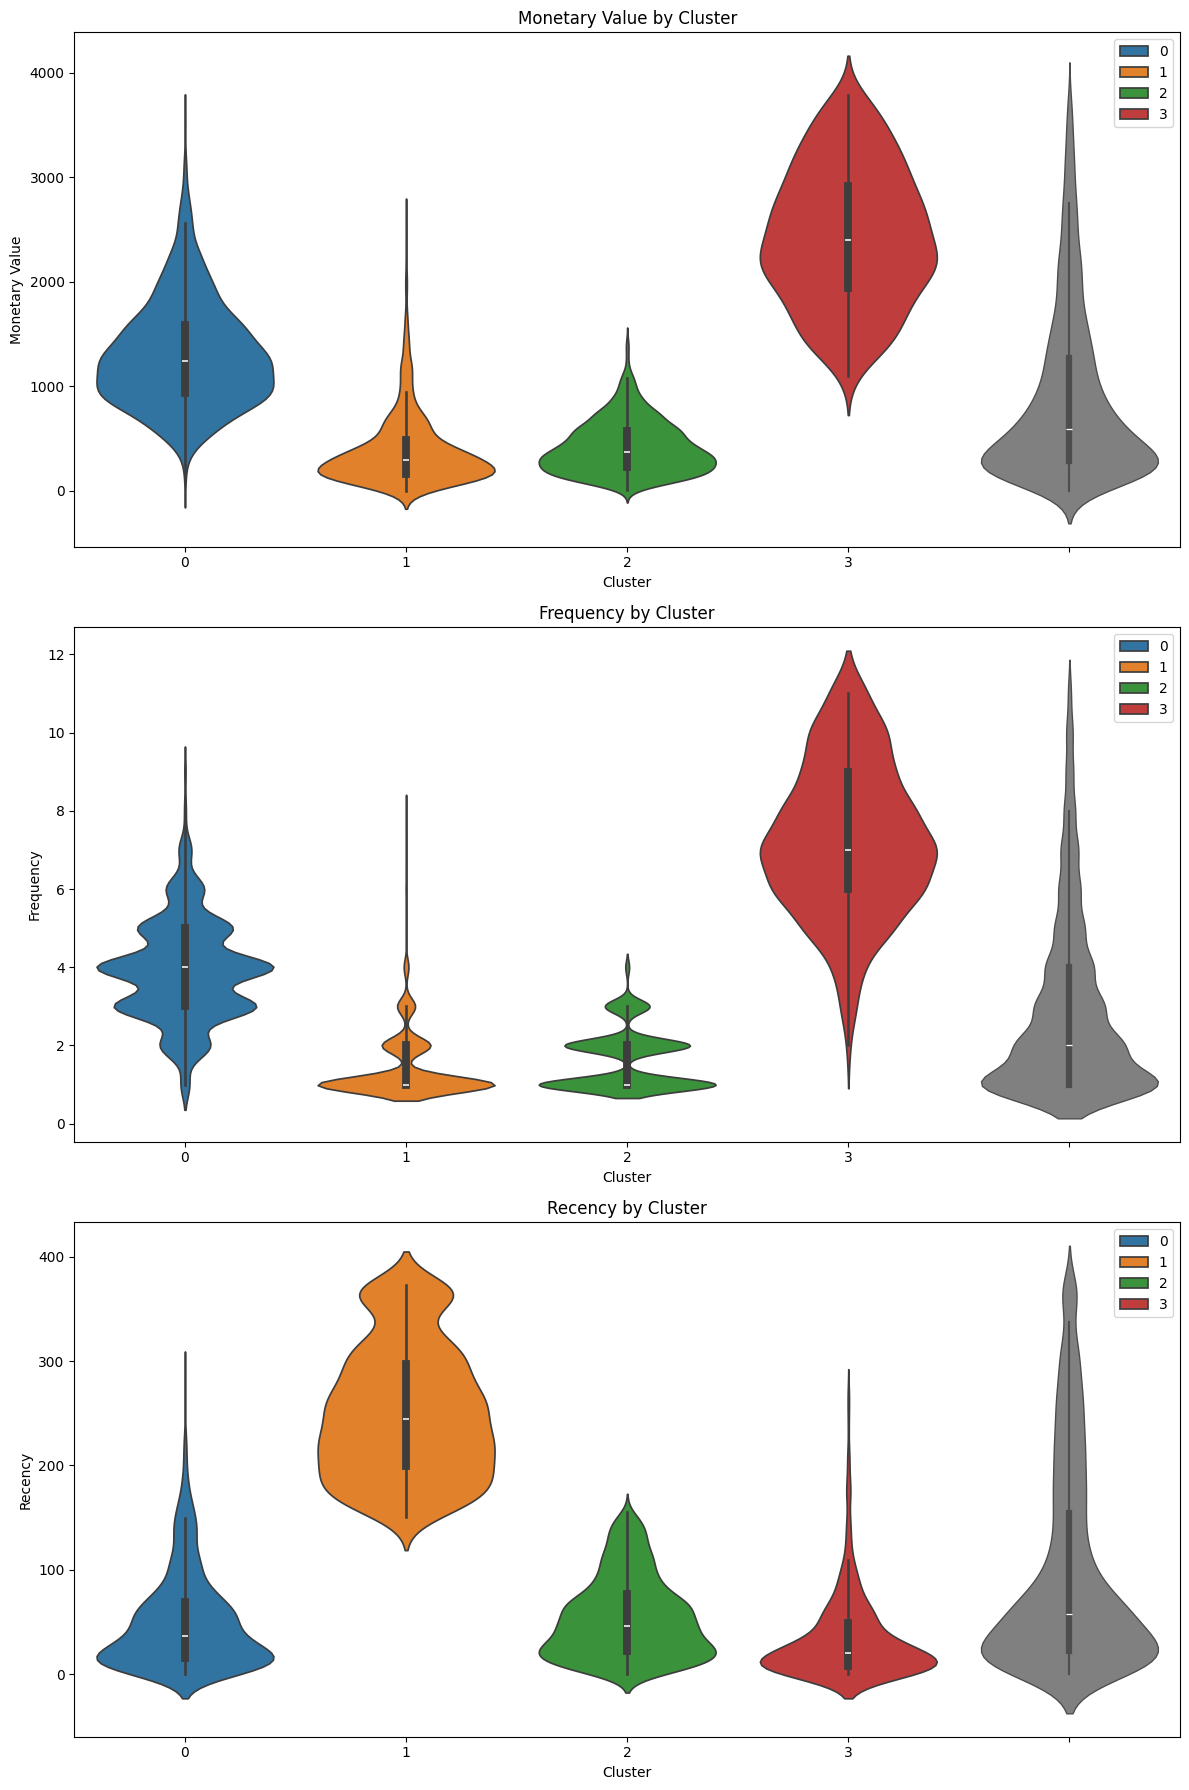

In [61]:
plt.figure(figsize=(12, 18))

plt.subplot(3, 1, 1)
sns.violinplot(x=non_outliers_df['Cluster'], y=non_outliers_df['MonetaryValue'], palette=cluster_colors, hue=non_outliers_df["Cluster"])
sns.violinplot(y=non_outliers_df['MonetaryValue'], color='gray', linewidth=1.0)
plt.title('Monetary Value by Cluster')
plt.ylabel('Monetary Value')

plt.subplot(3, 1, 2)
sns.violinplot(x=non_outliers_df['Cluster'], y=non_outliers_df['Frequency'], palette=cluster_colors, hue=non_outliers_df["Cluster"])
sns.violinplot(y=non_outliers_df['Frequency'], color='gray', linewidth=1.0)
plt.title('Frequency by Cluster')
plt.ylabel('Frequency')


plt.subplot(3, 1, 3)
sns.violinplot(x=non_outliers_df['Cluster'], y=non_outliers_df['Recency'], palette=cluster_colors, hue=non_outliers_df["Cluster"])
sns.violinplot(y=non_outliers_df['Recency'], color='gray', linewidth=1.0)
plt.title('Recency by Cluster')
plt.ylabel('Recency')

plt.tight_layout()
plt.show()

**Cluster 0 (Blue): “Retain”**

Justification: Customers in this group typically spend a little over 1,000, with a median around 1,237. They buy regularly (about 4 to 6 orders), but their last purchase is usually 50–100 days ago. The main challenge is retention to preserve their loyalty and spending level.

Action: Implement a loyalty program, offer personalized deals, and maintain regular contact to strengthen engagement.


**Cluster 1 (Orange): “Re‑engage”**

Justification: This group includes occasional, low‑value buyers who have not purchased recently. The goal is to re‑engage them and encourage a return to buying habits. Most spent less than 500 (median 289.68), placed only one order, and their last purchase was more than 250 days ago in most cases.

Action: Use targeted marketing campaigns, special discounts, or reminders to encourage them to come back and purchase again.


**Group 2 (Green): “Loyalty”**  
*Justification:* This group represents the least active and least profitable customers, but they have purchased recently. They may be new customers or customers who need nurturing to increase engagement and spending. Most spent less than 500 (median 371.59), placed only one order, and their last purchase was generally around 46 days ago.  
*Action:* Focus on relationship building, offer excellent customer service, and provide incentives to encourage more frequent purchases.


**Group 3 (Red): “Reward”**

Justification: This group includes loyal and very regular customers, many of whom continue to purchase consistently. These are your most loyal customers, and rewarding their loyalty is essential to maintain engagement.  
Most spent more than 2,000 (median 2,405.015), placed about 7 orders, and their last purchase was around 20 days ago.

Action: Implement a strong loyalty program, offer exclusive deals, and show appreciation to keep them satisfied and engaged.


**Summary of group names:**

- Group 0 (Blue): “Retain”
- Group 1 (Orange): “Re‑engage”
- Group 2 (Green): “Encourage”
- Group 3 (Red): “Reward”


### Handle Outliers

For now, we only considered customers who were neither Frequency outliers nor MonetaryValue outliers. However, as noted above, we distinguished three outlier groups:

- Outliers only for Frequency  
- Outliers only for MonetaryValue  
- Outliers for both features  

Let’s now analyze these three groups of individuals.


In [62]:
overlap_indices = Monetary_outliers_df.index.intersection(Frequency_outliers_df.index)

monetary_only_outliers = Monetary_outliers_df.drop(overlap_indices)
frequency_only_outliers = Frequency_outliers_df.drop(overlap_indices)
monetary_and_frequency_outliers = Monetary_outliers_df.loc[overlap_indices]

monetary_only_outliers["Cluster"] = -1
frequency_only_outliers["Cluster"] = -2
monetary_and_frequency_outliers["Cluster"] = -3

outlier_clusters_df = pd.concat([monetary_only_outliers, frequency_only_outliers, monetary_and_frequency_outliers])

outlier_clusters_df

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,Recency,Cluster
9,12357.00,11229.99,1,2010-11-16 10:05:00,23,-1
25,12380.00,4782.84,4,2010-08-31 14:54:00,100,-1
42,12409.00,12346.62,4,2010-10-15 10:24:00,55,-1
48,12415.00,19468.84,4,2010-11-29 15:07:00,10,-1
61,12431.00,4145.52,11,2010-12-01 10:03:00,8,-1
...,...,...,...,...,...,...
4235,18223.00,7516.31,12,2010-11-17 12:20:00,22,-3
4236,18225.00,7545.14,15,2010-12-09 15:46:00,0,-3
4237,18226.00,6650.83,15,2010-11-26 15:51:00,13,-3
4241,18231.00,4791.80,23,2010-10-29 14:17:00,41,-3


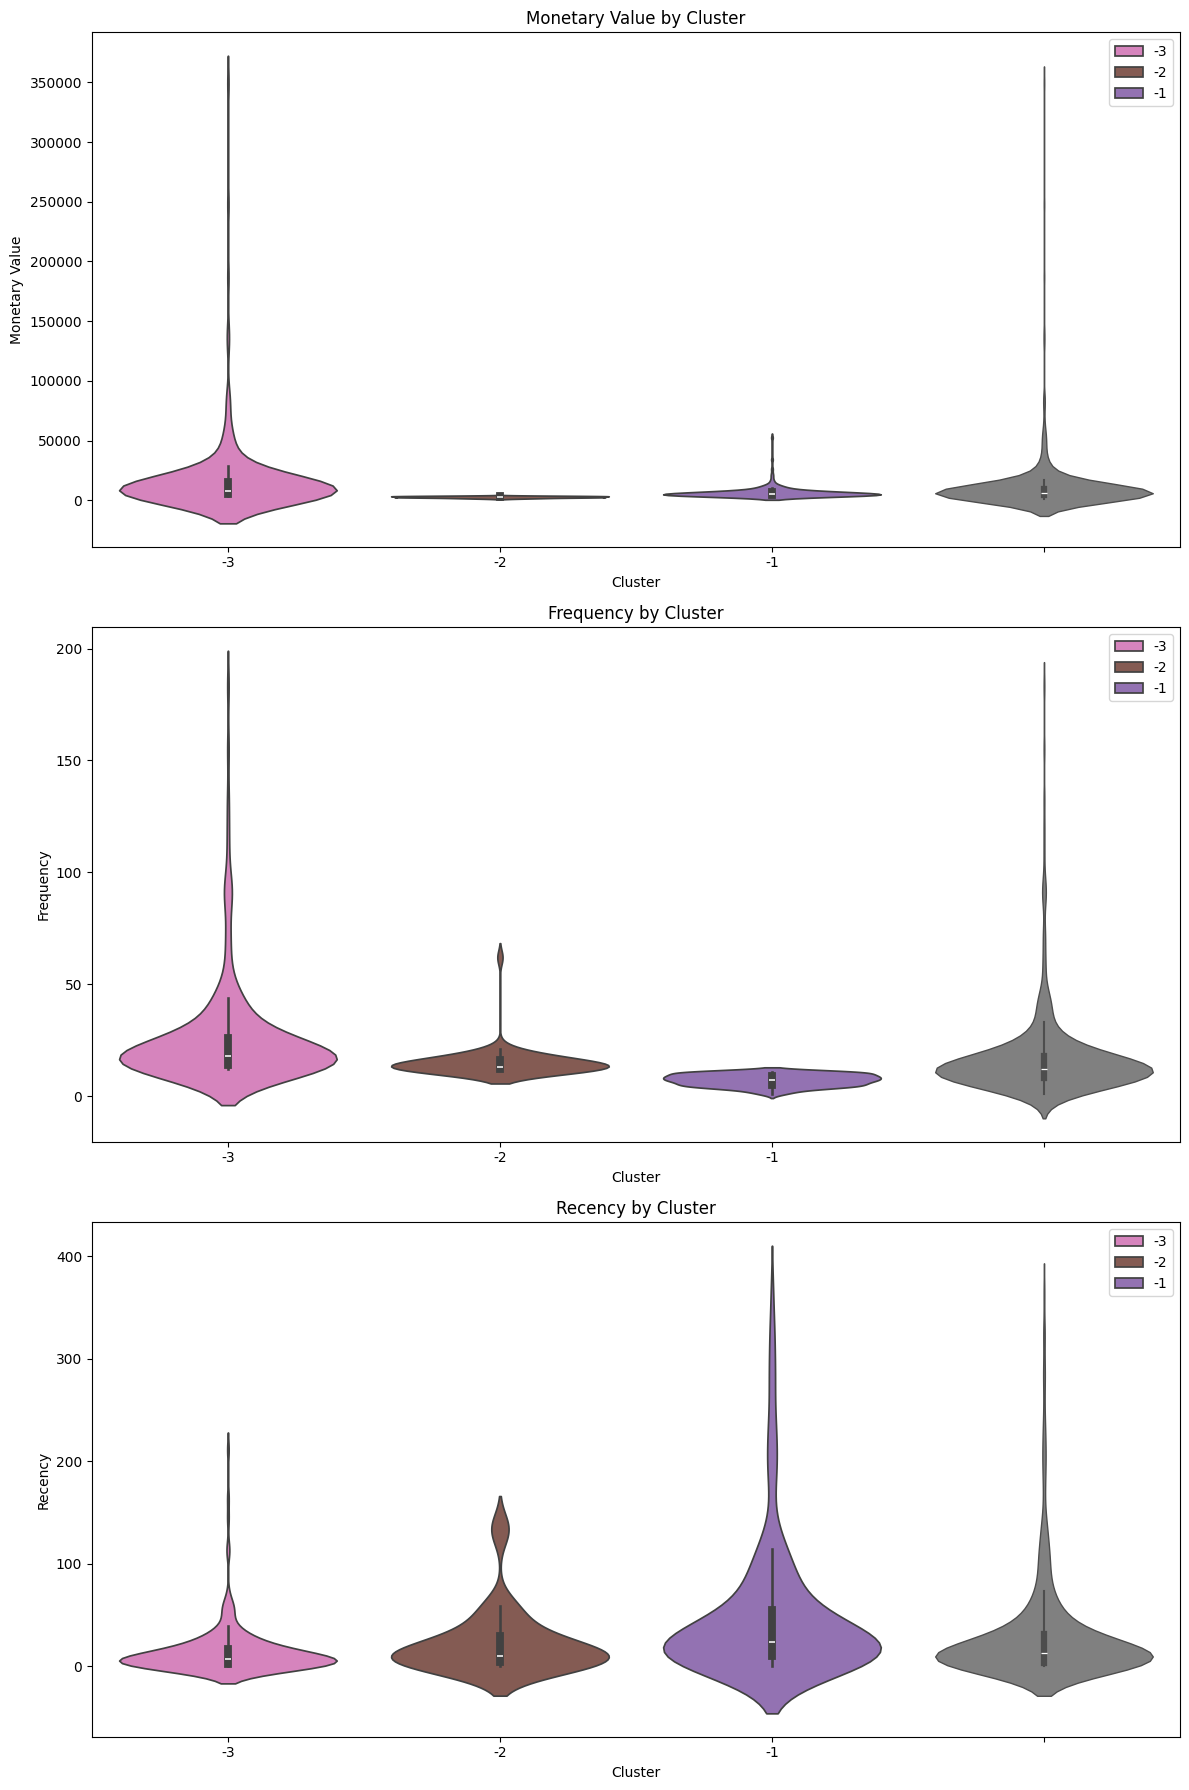

In [63]:
cluster_colors = {-1: '#9467bd',
                  -2: '#8c564b',
                  -3: '#e377c2'}

plt.figure(figsize=(12, 18))

plt.subplot(3, 1, 1)
sns.violinplot(x=outlier_clusters_df['Cluster'], y=outlier_clusters_df['MonetaryValue'], palette=cluster_colors, hue=outlier_clusters_df["Cluster"])
sns.violinplot(y=outlier_clusters_df['MonetaryValue'], color='gray', linewidth=1.0)
plt.title('Monetary Value by Cluster')
plt.ylabel('Monetary Value')

plt.subplot(3, 1, 2)
sns.violinplot(x=outlier_clusters_df['Cluster'], y=outlier_clusters_df['Frequency'], palette=cluster_colors, hue=outlier_clusters_df["Cluster"])
sns.violinplot(y=outlier_clusters_df['Frequency'], color='gray', linewidth=1.0)
plt.title('Frequency by Cluster')
plt.ylabel('Frequency')

plt.subplot(3, 1, 3)
sns.violinplot(x=outlier_clusters_df['Cluster'], y=outlier_clusters_df['Recency'], palette=cluster_colors, hue=outlier_clusters_df["Cluster"])
sns.violinplot(y=outlier_clusters_df['Recency'], color='gray', linewidth=1.0)
plt.title('Recency by Cluster')
plt.ylabel('Recency')

plt.tight_layout()
plt.show()

* Cluster -1 (Atypical monetary value) **PAMPER**:  
Characteristics: High‑spending customers, but not necessarily frequent buyers. Their purchases are large but occasional.  

The median MonetaryValue in this cluster is 5,043.4.  
The median Frequency is 7, which indicates several orders but not extremely high.  
Their last purchase is relatively far back. The median Recency is 27 days, meaning their last purchases were a while ago.

This may represent affluent customers who spend a lot on certain occasions but still pay attention to their budget.

Potential strategy: Focus on retention with personalized offers or premium services tailored to their high purchasing power.

* Cluster -2 (Atypical frequency) **UPSELL**:  
Characteristics: Customers who buy often but spend less per purchase. They are regularly engaged but have strong upsell potential.  
The median Frequency for this group is 13, meaning at least 50% of customers placed 13 orders.

Potential strategy: Use loyalty programs or bundles to increase basket size given their high purchase frequency.

* Cluster -3 (Atypical monetary value & frequency) **DELIGHT**:  
Characteristics: The most valuable outliers, with very high spending and frequent purchases. They are likely premium customers who deserve special attention.  
The median Frequency is 18 and the median MonetaryValue is 7,802.

Potential strategy: Develop VIP programs or exclusive offers to maintain their loyalty and encourage long‑term engagement.


In [64]:
cluster_labels = {
    0: "RETAIN",
    1: "RE-ENGAGE",
    2: "NURTURE",
    3: "REWARD",
    -1: "PAMPER",
    -2: "UPSELL",
    -3: "DELIGHT"
}

In [65]:
full_clustering_df = pd.concat([non_outliers_df, outlier_clusters_df])

full_clustering_df

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,Recency,Cluster
0,12346.00,169.36,2,2010-06-28 13:53:00,164,1
1,12347.00,1323.32,2,2010-12-07 14:57:00,2,0
2,12348.00,221.16,1,2010-09-27 14:59:00,73,2
3,12349.00,2221.14,2,2010-10-28 08:23:00,42,0
4,12351.00,300.93,1,2010-11-29 15:23:00,10,2
...,...,...,...,...,...,...
4235,18223.00,7516.31,12,2010-11-17 12:20:00,22,-3
4236,18225.00,7545.14,15,2010-12-09 15:46:00,0,-3
4237,18226.00,6650.83,15,2010-11-26 15:51:00,13,-3
4241,18231.00,4791.80,23,2010-10-29 14:17:00,41,-3


In [66]:
full_clustering_df["ClusterLabel"] = full_clustering_df["Cluster"].map(cluster_labels)

full_clustering_df

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,Recency,Cluster,ClusterLabel
0,12346.00,169.36,2,2010-06-28 13:53:00,164,1,RE-ENGAGE
1,12347.00,1323.32,2,2010-12-07 14:57:00,2,0,RETAIN
2,12348.00,221.16,1,2010-09-27 14:59:00,73,2,NURTURE
3,12349.00,2221.14,2,2010-10-28 08:23:00,42,0,RETAIN
4,12351.00,300.93,1,2010-11-29 15:23:00,10,2,NURTURE
...,...,...,...,...,...,...,...
4235,18223.00,7516.31,12,2010-11-17 12:20:00,22,-3,DELIGHT
4236,18225.00,7545.14,15,2010-12-09 15:46:00,0,-3,DELIGHT
4237,18226.00,6650.83,15,2010-11-26 15:51:00,13,-3,DELIGHT
4241,18231.00,4791.80,23,2010-10-29 14:17:00,41,-3,DELIGHT


## Visualisation

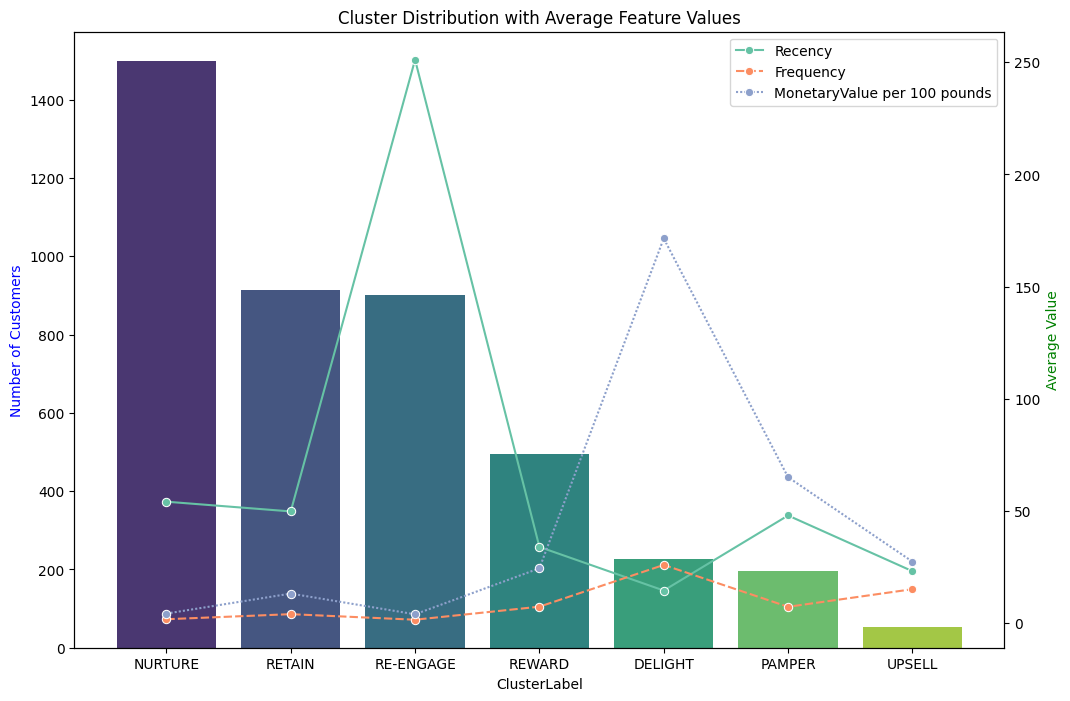

In [67]:
cluster_counts = full_clustering_df['ClusterLabel'].value_counts()
full_clustering_df["MonetaryValue per 100 pounds"] = full_clustering_df["MonetaryValue"] / 100.00
feature_means = full_clustering_df.groupby('ClusterLabel')[['Recency', 'Frequency', 'MonetaryValue per 100 pounds']].mean()

fig, ax1 = plt.subplots(figsize=(12, 8))

sns.barplot(x=cluster_counts.index, y=cluster_counts.values, ax=ax1, palette='viridis', hue=cluster_counts.index)
ax1.set_ylabel('Number of Customers', color='b')
ax1.set_title('Cluster Distribution with Average Feature Values')
ax2 = ax1.twinx()

sns.lineplot(data=feature_means, ax=ax2, palette='Set2', marker='o')
ax2.set_ylabel('Average Value', color='g')

plt.show()